<a href="https://colab.research.google.com/github/WenxiGu/text-mining/blob/main/4_Transformers_ModelosLenguaje_master_profesor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arquitectura Transformers

Durante muchos años, los modelos más utilizados en procesamiento de lenguaje natural (NLP) fueron las **redes neuronales recurrentes** (RNN) y sus variantes como **LSTM** y **GRU**. Estos modelos procesaban el texto secuencialmente, palabra por palabra, lo que dificultaba la paralelización y complicaba la captura de relaciones a largo plazo dentro del texto. En otras palabras, **tenían "poca memoria"** para retener información de partes distantes de la secuencia.

Esto cambió en 2017 con la publicación del influyente artículo "**Attention is All You Need**" (Vaswani et al.), que introdujo la arquitectura **Transformer**. Esta propuesta eliminaba completamente la recurrencia y se apoyaba en un nuevo mecanismo llamado **Self-Attention**, que permite al modelo **procesar todas las palabras de una secuencia al mismo tiempo**, capturando de forma eficiente las relaciones entre ellas. Además, esta arquitectura es **altamente paralelizable**, lo que permite entrenarla más rápido y con mayor escala.


Desde su aparición, los Transformers se han convertido en la base de casi todos los avances recientes en NLP, y han dado lugar a modelos tan conocidos como **BERT** (2018), **GPT** (2018) y evoluciones de estos.


En las siguientes secciones, vamos a explorar en más detalle el funcionamiento del encoder de la arquitectura **Transformer**, que es la parte utilizada en modelos como **BERT** o **RoBERTa**.

El objetivo es descubrir y comprender los componentes principales de este tipo de modelos centrándonos en **Tokenización**, **Input embedding**, **Positional Encoding** y **Self-Attention**.  Ya que cada uno de estos bloques cumple un rol esencial para que el modelo pueda representar y procesar el texto de manera contextual y eficiente.

Transformer 架构

多年来，自然语言处理（NLP）中最常用的模型是**循环神经网络（RNN）**及其变体，如 LSTM 和 GRU。这些模型按顺序逐词处理文本，难以并行化，也不易捕捉文本中的长距离关系。换句话说，它们在保留序列中远处信息方面“记忆力不足”。

这一状况在 2017 年随具有影响力的论文 “Attention is All You Need”（Vaswani 等）而改变。论文提出了 Transformer 架构，完全去除了循环，引入了名为 自注意力（Self-Attention） 的新机制，使模型能够同时处理序列中的所有词，高效捕捉它们之间的关系。此外，该架构高度可并行化，因此训练更快、规模更大。

自出现以来，Transformer 成为几乎所有 NLP 近期突破的基础，催生了诸如 BERT（2018）、GPT（2018） 及其后续演进的模型。

在接下来的部分中，我们将更详细地探讨 Transformer 编码器（encoder） 的工作方式——这部分被应用在 BERT、RoBERTa 等模型中。

本节目标是理解这类模型的关键组件，重点介绍：分词（Tokenization）、输入嵌入（Input embedding）、位置编码（Positional Encoding） 与 自注意力（Self-Attention）。这些模块各自承担着核心作用，使模型能够以上下文方式、高效地表示与处理文本。

## 🔹 Frase de ejemplo

A lo largo de este notebook vamos a trabajar con dos frases de ejemplo en la que aparece el mismo término polisémico en diferentes contextos.

In [1]:
sentence1 = "El ratón salió corriendo delante del gato."
sentence2 = "El ratón no respondía, así que reinicié el ordenador"

## Arquitectura Encoder


Para estructurar mejor la comprensión de la arquictura Transformer-Encoder, vamos a dividir el procesado de sus datos en dos fases:



*   a. Entrada del Transformers
*   b. Encoder






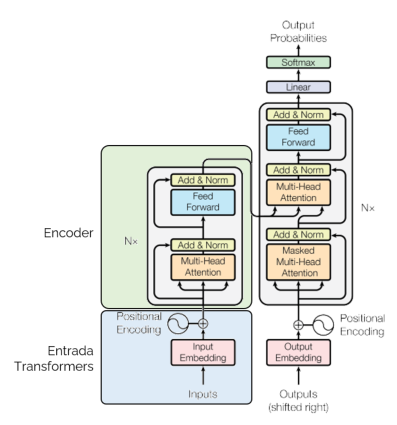


En primer lugar vamos a cargar el modelo y el tokenizador del modelo [`PlanTL-GOB-ES/bsc-bio-es`](https://huggingface.co/PlanTL-GOB-ES/bsc-bio-es) utilizando dos clases de la librería Transformers.

> Este modelo ha sido entrenado por el Barcelona Supercomputing Center.


In [ ]:
from transformers import AutoTokenizer, AutoModel
model_name = "PlanTL-GOB-ES/bsc-bio-es"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModel.from_pretrained(model_name)


### 1. Entrada del Transformers

La **entrada del Transformer** tiene como objetivo preparar el texto que se quiere procesar para que pueda ser entendido por la arquitectura del modelo.

Este proceso se divide en tres fases fundamentales:

1. **Tokenización**: convierte el texto en unidades básicas llamadas tokens, que pueden ser palabras,subpalabras o incluso caracteres, dependiendo del modelo.
2. **Input Embedding**: transforma estos tokens en vectores numéricos que capturan propiedades semánticas y sintácticas básicas.
3. **Codificación Posicional** (Positional Encoding): añade información sobre el orden de los tokens en la secuencia, ya que el Transformer no tiene una noción implícita del orden como lo hacen las redes recurrentes.




1. Transformer 的输入

Transformer 的输入，旨在把要处理的文本准备好，让模型架构能理解。

流程分三步：

分词（Tokenization）
把文本切成基本单元 token。根据模型不同，token 可以是词、子词（如 ##iendo 这种词片段）或字符。

输入嵌入（Input Embedding）
把这些 token 映射为数值向量，捕捉基础的语义与句法信息。

位置编码（Positional Encoding）
为序列中的 token 加入位置信息。因为 Transformer 不像 RNN 那样天然有顺序感，需要显式注入顺序。

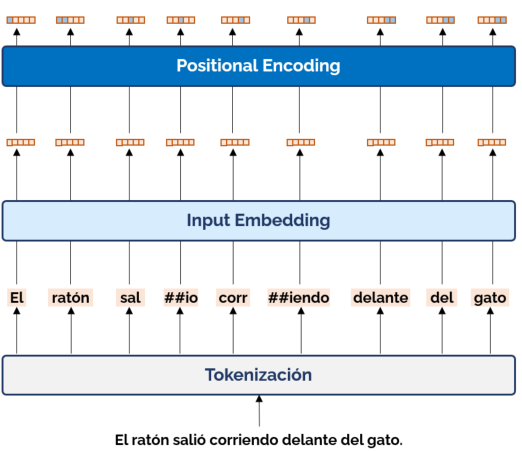

Durante este proceso, es posible acceder a los vectores generados en cada una de estas etapas, lo que nos permite observar cómo se transforma el texto paso a paso antes de llegar al bloque de atención (bloque encoder).

En este notebook trabajaremos con dos frases de ejemplo, y exploraremos cómo se procesan los datos en esta primera fase de entrada del Transformer, desde la tokenización hasta la codificación posicional.

#### a.Tokenizacion e Input Embedding



Antes de que el modelo pueda trabajar con texto, necesitamos convertirlo en un formato numérico. Para ello, el modelo de lenguaje dispone de un tokenizador que subdivide el texto de entrada en tokens.

En el proceso de tokenización, el modelo introduce un token especial al inicio y al final de la secuencia. El token especial de iinicio de secuencia suele tener la forma `[CLS]` o `<s>` según la arquitectura del modelo que se está utilizando. El token especial de final de secuencia suele ser `[SEP]` o `</s>`.

In [3]:
tokens1 = tokenizer.tokenize(sentence1, add_special_tokens=True)
tokens2 = tokenizer.tokenize(sentence2, add_special_tokens=True)
print("Tokens sentence 1:", tokens1)
print("Tokens sentence 2:", tokens2)

Keyword arguments {'add_special_tokens': True} not recognized.
Keyword arguments {'add_special_tokens': True} not recognized.


Tokens sentence 1: ['ĠEl', 'ĠratÃ³n', 'ĠsaliÃ³', 'Ġcorriendo', 'Ġdelante', 'Ġdel', 'Ġgato', '.']
Tokens sentence 2: ['ĠEl', 'ĠratÃ³n', 'Ġno', 'ĠrespondÃŃa', ',', 'ĠasÃŃ', 'Ġque', 'Ġreinici', 'Ã©', 'Ġel', 'Ġordenador']


Se puede observar que el tokenizador no sólo divide la frase en palabras, sino que en algunos casos las subdivide en subpalabras. Esto se hace para manejar de forma eficiente palabras raras o poco frecuentes, permitiendo que el modelo pueda entender y generalizar mejor a partir de partes comunes de las palabras, como raíces, prefijos o sufijos. Este tipo de tokenización ayuda al modelo a reutilizar piezas comunes del lenguaje, lo que reduce el tamaño del vocabulario necesario y mejora su capacidad para entender palabras nuevas o poco frecuentes, a partir de partes conocidas.

Por ejemplo, la palabra **“casitas”** podría descomponerse en dos subpalabras: **"cas"** y **"itas"**. Esto permite que el fragmento** "cas" **pueda reutilizarse en otras palabras como **“casa”, “caserío” o “casilla”**, mientras que **"itas"** podría aparecer en diminutivos como **“pequeñitas” o “bonitas”**.



El tokenizador no solo divide el texto en tokens, sino que también asigna un **identificador numérico único** a cada uno de ellos, de acuerdo con el vocabulario del modelo.


In [4]:
token_ids1 = tokenizer(sentence1, return_tensors="pt")
token_ids2 = tokenizer(sentence2, return_tensors="pt")
print("Token IDs sentence 1:", token_ids1['input_ids'])
print("Token IDs sentence 2:", token_ids2['input_ids'])

Token IDs sentence 1: tensor([[    0,   449, 14784, 13532, 24571,  8667,   328, 16966,    17,     2]])
Token IDs sentence 2: tensor([[    0,   449, 14784,   373, 48115,    15,   931,   298, 34536,   319,
           296, 10418,     2]])


Estos identificadores se asocian con los **input embeddings** de cada subpalabra del vocabulario, obtenido durante el proceso del entrenamiento del modelo.

En este punto, una palabra con diferentes acepciones tendrá el mismo input embedding asociado, ya que todavía no se le ha aplicado el modelo. Por ejemplo, podríamos obtener y comparar el embeddings de la palabra "ratón" para las frases de ejemplos:


In [6]:
# Obtengo los input embeddings para los token ids de las frases de ejemplo
embeddings1 = model.embeddings(token_ids1['input_ids'])
embeddings2 = model.embeddings(token_ids2['input_ids'])


import torch
# Comprobamos que los vectores del elemento 2 ("ratón")
torch.equal(embeddings1[:,2,:], embeddings2[:,2,:])

True

#### b. Positional Encoding

En los Transformers, como no hay recurrencia en la arquitectura, el modelo no sabe el orden de las palabras por sí mismo. Por eso se le añade a cada token una codificación posicional que le indica su lugar en la secuencia.

En el paper original de Transformers se propone una codificación generada con funciones seno y coseno que tiene patrones que permiten al modelo, durante su entrenamiento, inferir relaciones como cercacnía o distancia entre posiciones.

Aquí visualizamos cómo varían estos valores con la posición y la dimensión:



b. 位置编码（Positional Encoding）

在 Transformer 中，由于结构里没有循环，模型本身并不知道词在句子里的顺序。因此，需要给每个 token 加上一份位置编码，告诉它在序列中的位置。

在 Transformer 的原始论文里，位置编码用正弦/余弦函数生成，形成有规律的模式，便于模型在训练时推断不同位置之间的远近关系（如相邻或相隔多远）。

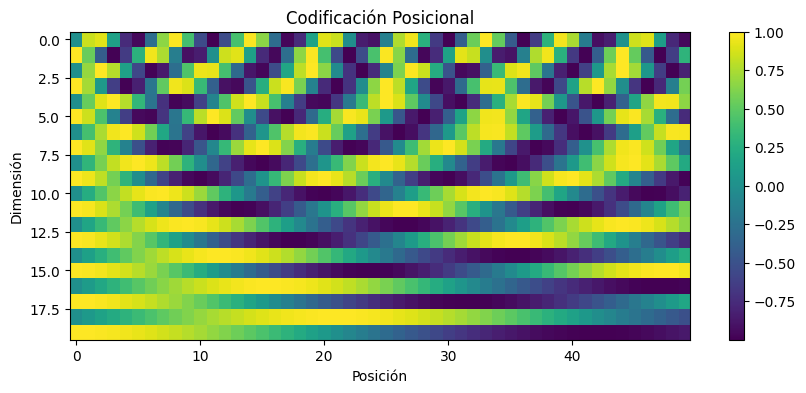

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#Numero de posiciones (numero de elementos de entrada)
position = np.arange(0, 50)
# Numero de dimensiones del modelo
dim = 64
angles = np.array([
    [pos / np.power(10000, (2 * (i//2)) / dim) for i in range(dim)]
    for pos in position
])
angles[:, 0::2] = np.sin(angles[:, 0::2])
angles[:, 1::2] = np.cos(angles[:, 1::2])

plt.figure(figsize=(10, 4))
plt.title("Codificación Posicional")
plt.imshow(angles.T[:20], aspect='auto', cmap='viridis')
plt.xlabel("Posición")
plt.ylabel("Dimensión")
plt.colorbar()
plt.show()

Como se observa, si un mismo término aparece en la** misma posición** dentro de distintas frases, entonces, después de aplicar la codificación posicional al embedding de entrada, **no debería haber diferencia**  en los vectores resultantes antes de introducirlos a las capas de atención (encoder).

Vamos a comprobarlo de forma práctica. Para ello, necesitamos pasar los `tokens_id` al modelo y extraer los **hidden states** (los vectores internos generados por el encoder en cada capa).
Esto nos permitirá analizar cómo se representa una misma palabra en distintos contextos y posiciones, y observar si esas representaciones son efectivamente similares o no.

拿到每层的 hidden states，并验证“同一词在相同位置、在只加了位置编码的输入端应该一样；但进了编码层后，会因上下文不同而变得不一样（被上下文化）”。

要点速读

model(..., output_hidden_states=True) 会返回一个对象，里面的 hidden_states 是一个 tuple：

hidden_states[0]：输入嵌入（token embedding + positional encoding），还没经过任何 Transformer 层。

hidden_states[1]：第 1 个 encoder 层输出

hidden_states[2]：第 2 个 encoder 层输出

… 直到最后一层。

每个 hidden_states[i] 的形状都是 (batch_size, seq_len, hidden_dim)（例如 BERT-base：hidden_dim=768，共有 12+1=13 个张量）。

因此：

若两句里相同 token恰好在同一位置（比如第 5 个），那在 hidden_states[0] 里它们的向量应几乎相同（同一个 token embedding + 同一位置编码）。

但在 hidden_states[1:]（经过注意力后的层）里，因为看到了不同上下文，这两个向量会逐层分化。

In [8]:
# PAsamos tokens de las frases de ejemplo por el modelo.
outputs1 = model(**token_ids1, output_hidden_states=True)
outputs2 = model(**token_ids2, output_hidden_states=True)

# Almacenamos los hidden_states para consultarlos posteriormente.
hidden_states1 = outputs1.hidden_states
hidden_states2 = outputs2.hidden_states

Para acceder a las sallidas de las capas, debo acceder a diferentes dimensiones de los hidden_states. Por ejemplo:

- `hidden_states[0]`: input embeddings (token embedding + position encoding)
- `hidden_states[1]`: output del primer encoder layer
- `hidden_states[2]`: output del segundo encoder layer


En este caso, accederemos a la capa inicial (0) para obtener los vectores antes de ser introducidos al primer bloque encoder:

In [9]:
# Acceso vectores despues del positional encodeding
emb_pos1 = hidden_states1[0][:,2,:]
emb_pos2 = hidden_states2[0][:,2,:]

# Comprobamos que los vectores son iguales
torch.equal(emb_pos1,emb_pos2)

True

En este caso ambos vectores son iguales. Si en una de las frases el término "ratón" no hubiera aparecido en segundo lugar, el vector resultante sería diferente debido al efecto del positional encoding.

### 2. Bloques Encoder

En este bloque, vamos a mostrar el efecto que tienen los** bloques del encoder**, compuestos principalmente por capas de **Self-Attention y Feed Forward**, a la hora de **mejorar la representación contextual** de cada token.

A medida que la información avanza por las capas del encoder, los vectores de los tokens dejan de representar únicamente el significado aislado de una palabra y comienzan a incorporar **información sobre su contexto**, es decir, sobre las palabras que la rodean.

Para visualizar este efecto, vamos a representar en el espacio vectorial algunos términos relacionados con los dominios con los que estábamos trabajando.

Concretamente, compararemos cómo se representan términos relacionados con el dominio de **animales** y términos relacionados con el dominio de **dispotivos de infomática**.

Para ello, primero generaremos ejemplos contextuales donde estos términos aparezcan en frases reales. Luego, extraeremos sus representaciones desde el modelo para analizar cómo varían en función del contexto y cómo se agrupan semánticamente.

展示编码器模块（主要由自注意力和前馈网络层组成）如何提升每个 token 的上下文表示。

随着信息在编码器的各层中前进，token 的向量不再只表示该词的孤立含义，而是开始融入其上下文信息，也就是周围词语带来的影响。

为了直观看到这个效果，我们会把一些与我们正在处理的主题域相关的术语映射到向量空间中进行展示。

具体来说，我们将比较两类术语的表示方式：

与动物领域相关的术语；

与计算机设备领域相关的术语。

做法是：先构造这些术语出现在真实句子中的上下文例子，然后从模型中抽取它们的表示，分析这些表示如何随上下文变化，以及如何在语义上聚类。

In [10]:

animales = [
    "El perro no dejaba de ladrar en la madrugada.",
    "El gato saltó ágilmente sobre la mesa.",
    "El elefante avanzaba con paso firme por la sabana.",
    "La jirafa alcanzó las hojas más altas del árbol.",
    "El león observaba atento desde la colina.",
    "El tigre se movía sigilosamente entre la maleza."
]

hardware_pc = [
    "La CPU empezó a recalentarse tras varias horas de uso.",
    "La GPU mostró un error al iniciar el juego.",
    "La RAM no era suficiente para correr el programa.",
    "El disco duro empezó a hacer un ruido extraño.",
    "La placa base tenía un condensador hinchado.",
    "El monitor parpadeó y luego se quedó en negro.",
    "El teclado dejó de responder de repente."
]

Para obtener su embeddings disiponemos de la función `get_embeddings()` que toma a su entrada una lista de documentos (frases) y extrae los embeddings relacionados con el segundo token de cada frase (el token de interes en cada caso)

In [11]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.manifold import TSNE # Import TSNE
import matplotlib.pyplot as plt
import numpy as np

def get_embeddings(word_list):
    embeddings = []
    for word in word_list:
        inputs = tokenizer(word, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        # Get the last hidden state. After the last encoder block.
        hidden_state = outputs.hidden_states[-1]
         # Use 0 for the [CLS] token, 2 for the term
        word_embedding = hidden_state[:, 2, :].numpy()
        embeddings.append(word_embedding)
    return np.concatenate(embeddings)

# Obten embeddings de cada crase
animal_embeddings = get_embeddings(animales)
hardware_embeddings = get_embeddings(hardware_pc)


Por otra parte, vamos a obtener los vectores contextuales del término "ratón" en nuestras frases de ejemplo:

In [12]:
# Raton como animal
raton_embedding_sent1 = hidden_states1[-1][:, 2, :].detach().numpy()
# Raton como dispotivo informatico
raton_embedding_sent2 = hidden_states2[-1][:, 2, :].detach().numpy()

Dado que tenemos vectores de muchas dimensiones, vamos a aplicar técnicas de reducción de dimensiones para representarlos en una gráfica de dispersión:

In [13]:
import umap  # Import UMAP
from sklearn.manifold import TSNE

# Combine all embeddings for t-SNE
all_embeddings_with_tokens = np.concatenate([
    animal_embeddings,
    hardware_embeddings,
    raton_embedding_sent1,
    raton_embedding_sent2
])
all_sentences = animales + hardware_pc + [sentence1, sentence2]
labels = (
    ["animales"] * len(animales) +
    ["hardware"] * len(hardware_pc) +
    ["prediction"] * 2
)

# Perform t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=3) # Set perplexity less than n_samples
reduced_embeddings = tsne.fit_transform(all_embeddings_with_tokens.reshape(all_embeddings_with_tokens.shape[0], -1))

# Separate reduced embeddings for plotting
animal_reduced = reduced_embeddings[:len(animales)]
hardware_reduced = reduced_embeddings[len(animales):len(animales) + len(hardware_pc)]
token2_embedding1_reduced = reduced_embeddings[len(animales) + len(hardware_pc):len(animales) + len(hardware_pc) + 1]
token2_embedding2_reduced = reduced_embeddings[len(animales) + len(hardware_pc) + 1:]

Preparamos un dataframe para poderlo representar graficamente:

In [14]:
import pandas as pd
df_tsne = pd.DataFrame(data=reduced_embeddings, columns=['x', 'y'])
df_tsne['sentence'] = all_sentences
df_tsne['label'] = labels
df_tsne["word"] = df_tsne.sentence.apply(lambda x: x.split()[1])

In [15]:
import plotly.express as px

fig = px.scatter(
        df_tsne, x='x', y='y',
        color="label", labels={'color': "label"},
    hover_data=["sentence"],
        text="word")
fig.update_traces(marker=dict(size=10))
fig.update_layout(
    title="t-SNE de embeddings",
    width=680,
    height=600,
    xaxis=dict(scaleanchor="y", scaleratio=1),
    margin=dict(l=60, r=60, t=60, b=60)

)
fig.update_traces(textposition="top right")


#### Visualización de atención (opcional)


Ahora vamos a observar gráficamente cómo funciona el mecanismo de atención explicado en el paso anterior.


La atención permite a cada palabra "mirar" a otras para entender su contexto. Podemos visualizar qué tokens se influencian entre sí dentro del modelo.


In [ ]:
!pip install bertviz
from bertviz import head_view
outputs = model(**token_ids1, output_attentions=True)
attention = outputs.attentions
tokens = tokenizer.convert_ids_to_tokens(token_ids1["input_ids"][0])
head_view(attention, tokens)

# See layer 9, color blue (3 por la cola)

## Introducción al entorno Huggingface: Language models, transformers y fine-tuning


HuggingFace 环境导论：语言模型、Transformers 与微调

语言模型推动并普及了 NLP 与文本挖掘的发展。语言模型能够理解（至少在统计层面上）它们所受训的语言。虽然它们并不能直接完成大多数任务，但通过微调（fine-tuning），可以把预训练模型适配到特定任务，最大化利用其对训练语言的知识。

语言模型以 Transformer 架构为基础。GPT 是首个基于该架构、可进行微调的预训练语言模型。自那以后，又出现了 BERT、GPT-2、XLM、DistilBERT、T5 等模型——它们在更大规模语料上训练，执行任务时的性能更强。

Los modelos de lenguaje han facilitado y democraizado el desarrollo del NLP y el Text Mining. Los modelos de lenguaje son capaces de _entender_ , al menos a nivel estadístico, la lengua en la que han sido entrenados. Aunque no son capaces de realizar la mayoría de las tareas, si que pueden ser afinados (_fine-tuned_) para que realicen tareas específicas, aprovechándose al máximo del conocimiento del idioma en el que fueron entrenados.

Los modelos de lenguaje se sostienen sobre la arquitectura **Transformers**. GPT fue el primer modelo de lenguaje pre-entrenado con esta arquitectura, con capacidades de afinamiento. Desde entonces se han publicado modelos como BERT, GPT-2, XLM, DistilBERT, T5... que han sido entrenados con mayores volúmenes de textos y son capaces de realizar las tareas con mayor rendimiento.


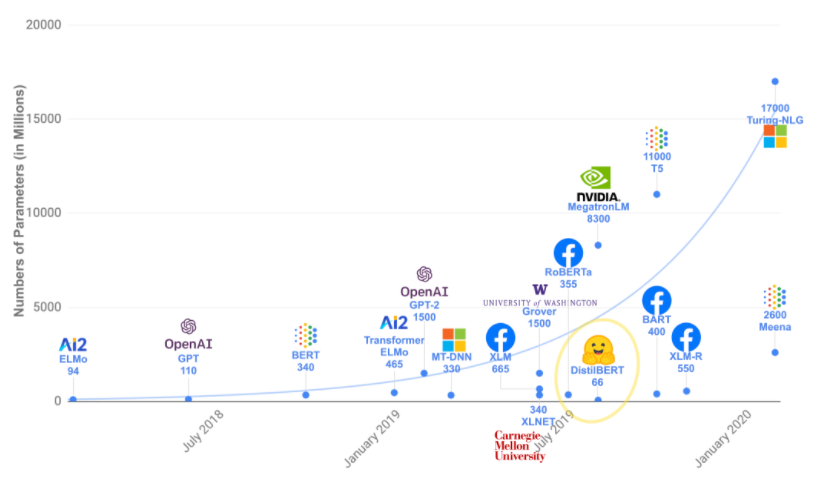

Los modelos de lenguaje son publicados por organismos con grandes capacidades de cálculos como centros de investigación, universidades o empresas tecnológicas; para que puedan ser afinados por la comunidad cientifico-tecnológica para múltiples propósitos.

El proceso de utilizar y ajustar modelosd e lenguaje es relativamente sencillo gracias a librarías como [Transformers](https://huggingface.co/docs/transformers/index), desarrollada por el equipo de HuggingFace🤗. Esta librería permite seleccionar modelos de un hub público, preparar tus datos, y afinar un modelo para realizar la tarea que desees. Esta librería tiene un gran apoyo de la comunidad, que fomenta la reutilización y apertura tanto de los datos como de los modelos construidos. Gracias a todo esto es mucho más fácil que nunca conseguir rendimientos state-of-the-art sin disponer de grandes volúmenes de datos.


### ¿Qué ofrece el ecosistema Hugging Face? <a name="id2_1"></a>


El entrenamiento de modelos de lenguaje y su ajuste requiere de conocimientos avanzados en entrenamiento de redes neuronales a través de herramientas como *pytorch*, además de conocimientos de ingeniería de software que permitan la optimización de los procesos, computacionalmente exigentes.

El ecosistema de HuggingFace surge como herramienta para acelerar y simplificar al máximo el entrenamiento de modelos de NLP basados en Transformers. Para ello existen una serie de librerías que permiten cargar conjuntos de datos (🤗 *Datasets*), modelos pre-entrenados (🤗 *Models*) y métricas y funciones de evaluación (🤗 *Metrics*) a un entorno de ejecución Python.

Una vez cargados esos conjuntos de datos se pueden utilizar librerías adicionales para preparar el texto de entrada al modelo (🤗 *Tokenizers*), el ajuste del modelo (🤗 *Transformers*) y su entrenamiento (🤗 *Accelerate*) de forma eficiente.


<center><img src="https://www.oreilly.com/api/v2/epubs/9781098136789/files/assets/nlpt_0109.png" alt="Ecosistema de Hugging Face" width="300"/></center>


Hugging Face dispone de un [**Hub de modelos**](https://huggingface.co/models) que permite la reutilización de componentes entrenados por la comunidad. En este Hub se pueden encontrar modelos de lenguaje pre-entrenados o modelos ya ajustados para hacer tareas específicas como traducción o búsqueda de respuestas. En este momento, existen modelos para más de 100 lenguas y más de 30 tareas de NLP. Las principales empresas del sector como [Facebook](https://huggingface.co/facebook), [Google](https://huggingface.co/google) o [Microsoft](https://huggingface.co/microsoft) utilizan este marketplace para compartir los recursos que generan con la comunidad. Instituciones de investigación como [Allen Institute for AI](https://huggingface.co/allenai) o el [BSC](https://huggingface.co/BSC-TeMU) también lo utilizan para compartir gran parte de los recursos del lenguaje que generan en sus proyectos.
<center><img src="https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Hugging-Face-Pre-trained-Models-How-to-Find-the-Best-One-for-Your-Task_5.png?resize=795%2C422&ssl=1" alt="Hugging Face model hub" width="400"/></center>




Adicionalmente, el universo Hugging Face también pone a disposición de los usuarios herramientas para generar aplicaciones demostrativas de IA de forma sencilla a través de su herramienta [**Spaces**](https://huggingface.co/spaces), así como un repositorio de [**datasets**](https://huggingface.co/datasets). También ofrece soluciones de empresariales para [servir modelos](https://huggingface.co/pricing) de forma sencilla.


### 🤗 HuggingFace Transformers

HuggingFace está construido sobre el objeto ``pipeline()``. Esta función permite abstraerse de la complejidad del código y focalizar los esfuerzos en la atarea que se quiere conseguir realizar.

Pipeline permite, entre otras cosas, cargar pipeline pre-entrenada para diferentes tareas como análisis de sentimiento, text-generation o traducción de forma muy sencilla.

En primer lugar se cargaría el módulo

In [18]:
from transformers import pipeline



*   Análisis de sentimiento



In [ ]:
sent_class = pipeline("sentiment-analysis")
sent_class("I hate that rythm, but I love the guitar sound")

*   Generación de texto


In [ ]:
gen_text = pipeline("text-generation", model="distilgpt2")
gen_text("I hate that rythm, but", max_length=50)

In [ ]:
generator_es = pipeline("text-generation", model="flax-community/gpt-2-spanish")
texto  = "Querido Amazon, la última semana me llegó el teléfono Samsung S20. Al principio todo estaba funcionancio bien, pero de pronto, la pantalla se puso a parpadear sin parar hasta que empezó a salir humo de la batería y el dispositivo se apagó. Creo que esto es culpa del fabricante y me gustaría alguna solución. Un saludo, Luis."
respuesta = "Estimado Luis, siento oir que su teléfono estaba defectuoso."
prompt = texto + "\n\nServicio al cliente:\n" + respuesta

outputs = generator_es(prompt, max_length=180)
print(outputs[0]["generated_text"])

- **Traducción**

In [ ]:
translator_es = pipeline("translation_en_to_fr")
print(translator_es("How old are you? Are you a old enough to enter this pub?")[0]["translation_text"])